# Pesudocode

In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

if not ".." in sys.path:
    sys.path.append("..")

In [ ]:
import torch

from lit_modules.litdatamodules.lit_lamem import LitLaMemDataModule
from datasets.LaMem.LaMemDataset import LaMem

In [ ]:
from time import time

start = time()
root = "/home/soroush1/projects/def-kohitij/soroush1/pretrain-imagenet/data/LaMem/lamem_images/lamem"

data = LitLaMemDataModule(
    root=root, num_workers=1, batch_size=128, dev_mode=False, desired_image_size=224
)
data.setup("train")

train_dl = data.train_dataloader()
x, y = next(iter(train_dl))

print(f"{abs(start - time())}")
print(f"{x.size() = }")

In [ ]:
import gc

del data, train_dl, x, y

gc.collect()

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np

# Select 20 random images and their scores
indices = torch.randperm(len(x))[:20]
selected_images = x[indices]
selected_scores = y[indices]

# Convert images to PIL images for plotting
to_pil = ToPILImage()

# Plotting the images with memorability scores as titles
fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # Adjust the size as needed
axes = axes.ravel()

for i, (img, score) in enumerate(zip(selected_images, selected_scores)):
    img = to_pil(img)  # Convert to PIL for display
    axes[i].imshow(np.asarray(img))
    axes[i].set_title(f"Memorability Score = {score:.2f}")
    axes[i].axis("off")  # Hide axes

plt.tight_layout()
plt.show()

In [ ]:
from lit_modules.litmodels.lit_vgg import VGGRegression

from lit_modules.litmodels.lit_resnet import LitResNet50

import torch.nn.functional as F

In [ ]:
# Example usage
model = LitResNet50(learning_rate=1e-4)

# Example input tensor (batch size, channels, height, width)
input_tensor = torch.randn(8, 3, 224, 224)

# Get the regression output
output = model(input_tensor)
print(output)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root = "/home/soroush1/projects/def-kohitij/soroush1/pretrain-imagenet/data/LaMem/lamem_images/lamem/"

data = LitLaMemDataModule(root=root, num_workers=1, batch_size=32, dev_mode=True)
data.setup("train")

train_dl = data.train_dataloader()
x, y = next(iter(train_dl))


model = VGGRegression(output_dim=1)
model.to(device)


for x, y in tqdm(train_dl):
    x = x.to(device)
    y = y.to(device)
    
    output = model(x)
    
    loss = F.mse_loss(output.squeeze(), y)
    
    print(f"{loss = }")

del x, y, data, train_dl
del model

import gc

# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Collect garbage
gc.collect()

# Lightning

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if not ".." in sys.path:
    sys.path.append("..")

In [3]:
import torch

from lit_modules.litdatamodules.lit_lamem import LitLaMemDataModule
from lit_modules.litmodels.lit_googlenet import LitGoogleNet


from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import DeviceStatsMonitor, StochasticWeightAveraging

from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import TensorBoardLogger

from lightning import Trainer

from tqdm.notebook import tqdm

### Experiments 

- Version0
- Version1
- Version2
    - Experiment:
        - First Run on LaMem Dataset
        - Finding the Batch size
        - Finding the Learning Rate
    - Result:
        - Batch size = 96
        - LR = 1e-4

- Version7
    - Experiment:
        - First Run on LaMem Dataset

In [ ]:
data_path = "../data/LaMem/lamem_images/lamem/"
datamodule = LitLaMemDataModule(
    root=data_path, batch_size=128, num_workers=3, dev_mode=False
)
tb_logger = TensorBoardLogger("./google_net_lalem")

# 0.00017378008287493763
model = LitGoogleNet(learning_rate=0.00017378008287493763)

trainer = Trainer(
    max_epochs=500,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    fast_dev_run=False,
    devices="auto",
    accelerator="gpu",
    num_nodes=1,
    strategy="auto",
    # overfit_batches=0.1,
    gradient_clip_val=0.5,
    logger=tb_logger,
    profiler="simple",
    # check_val_every_n_epoch = 1,
    # log_every_n_steps=1
)

trainer.fit(model=model, datamodule=datamodule)

/lustre06/project/6067616/soroush1/pretrain-imagenet/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lustre06/project/6067616/soroush1/pretrain-imagenet ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | In sizes          | Out sizes
----------------------------------------------------------------------------------
0 | model     | GoogleNetRegression | 12.0 M | [64, 3, 224, 224] | [64, 1]  
1 | criterion | MSELoss             | 0      | ?                 | ?        
----------------------------------------------------------------------------------
12.0 M    Trainable params
0    

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

/lustre06/project/6067616/soroush1/pretrain-imagenet/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lustre06/project/6067616/soroush1/pretrain-imagenet ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/lustre06/project/6067616/soroush1/pretrain-imagenet/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lustre06/project/6067616/soroush1/pretrain-imagenet ...
You are using a CUDA device

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00017378008287493763
Restoring states from the checkpoint path at /lustre06/project/6067616/soroush1/pretrain-imagenet/notebook/.lr_find_641323fe-5aa5-4d22-8ba5-346e32c5eb52.ckpt
Restored all states from the checkpoint at /lustre06/project/6067616/soroush1/pretrain-imagenet/notebook/.lr_find_641323fe-5aa5-4d22-8ba5-346e32c5eb52.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

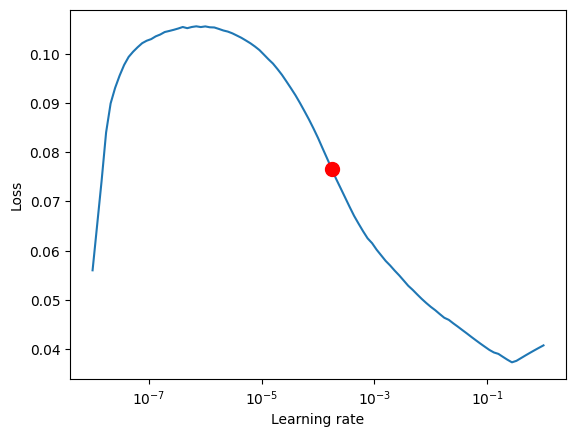

In [4]:
data_path = "../data/LaMem/lamem_images/lamem/"
datamodule = LitLaMemDataModule(
    root=data_path, batch_size=128, num_workers=2, dev_mode=False
)
tb_logger = TensorBoardLogger("./google_net_lalem")

model = LitGoogleNet(learning_rate=0.01)

trainer = Trainer(
    max_epochs=200,
    # callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    callbacks=[StochasticWeightAveraging(swa_lrs=1e-2)],
    fast_dev_run=False,
    devices="auto",
    accelerator="gpu",
    num_nodes=1,
    strategy="auto",
    overfit_batches=1,
    gradient_clip_val=0.5,
    logger=tb_logger,
    # check_val_every_n_epoch = 1,
    # log_every_n_steps=1
)

# trainer.fit(model=model, datamodule=datamodule)

tuner = Tuner(trainer)
# Auto-scale batch size by growing it exponentially (default)
# tuner.scale_batch_size(model, datamodule=datamodule, mode="power")

# finds learning rate automatically
# sets hparams.lr or hparams.learning_rate to that learning rate
# Run learning rate finder
lr_finder = tuner.lr_find(model, datamodule=datamodule)

# Results can be found in
print(lr_finder.results)

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

fig = lr_finder.plot(suggest=True)

# # update hparams of the model
# model.hparams.learning_rate = new_lr

In [ ]:
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()

In [5]:
new_lr

0.00017378008287493763

In [31]:
import torch
import torch.nn as nn
from torchvision.models import googlenet
import lightning as L
import torch.optim as optim


class GoogleNetRegression(nn.Module):
    def __init__(self, num_output_features=1):
        super().__init__()
        # Load a pre-trained ResNet-50 model
        self.googlenet_model = googlenet(weights=None, init_weights=True)
        # Replace the classifier layer for regression
        num_ftrs = self.googlenet_model.fc.in_features
        self.googlenet_model.fc = nn.Linear(num_ftrs, num_output_features)
        # If your targets are in the range [0, 1], you might want to add a sigmoid layer:
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.googlenet_model(x)
        print(f"{type(x)}")
        # x = self.sigmoid(x)
        return x